In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, GRU
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
df = pd.read_csv('data.csv', index_col=False)
print(df.columns)
df.head()

Index(['clouds', 'datetime', 'dewpt', 'dhi', 'dni', 'ghi', 'pres', 'rh', 'slp',
       'temp', 'wind_gust_spd', 'wind_spd', 'precip'],
      dtype='object')


,clouds,datetime,dewpt,dhi,dni,ghi,pres,rh,slp,temp,wind_gust_spd,wind_spd,precip
0,18,01/01/2021,4.1,40,331,210,1025,56,1025,13.2,8.0,1.9,0.0
1,17,02/01/2021,7.0,40,331,211,1022,66,1022,14.0,6.4,1.4,0.0
2,90,03/01/2021,9.7,40,332,211,1021,74,1021,14.6,7.2,1.6,0.0
3,98,04/01/2021,9.4,41,332,212,1020,59,1021,17.7,6.0,1.0,0.0
4,100,05/01/2021,13.6,41,332,212,1020,76,1020,18.1,5.6,1.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   clouds         1669 non-null   int64  
 1   datetime       1669 non-null   object 
 2   dewpt          1669 non-null   float64
 3   dhi            1669 non-null   int64  
 4   dni            1669 non-null   int64  
 5   ghi            1669 non-null   int64  
 6   pres           1669 non-null   int64  
 7   rh             1669 non-null   int64  
 8   slp            1669 non-null   int64  
 9   temp           1669 non-null   float64
 10  wind_gust_spd  1669 non-null   float64
 11  wind_spd       1669 non-null   float64
 12  precip         1669 non-null   float64
dtypes: float64(5), int64(7), object(1)
memory usage: 169.6+ KB


In [4]:
# Vẽ biểu đồ chuỗi thời gian với cột 'precip' sử dụng Plotly
fig = px.line(df, x='datetime', y='precip', title='Biểu đồ lượng mưa theo thời gian')
fig.update_xaxes(title_text='Thời gian')
fig.update_yaxes(title_text='Lượng mưa')
fig.show()

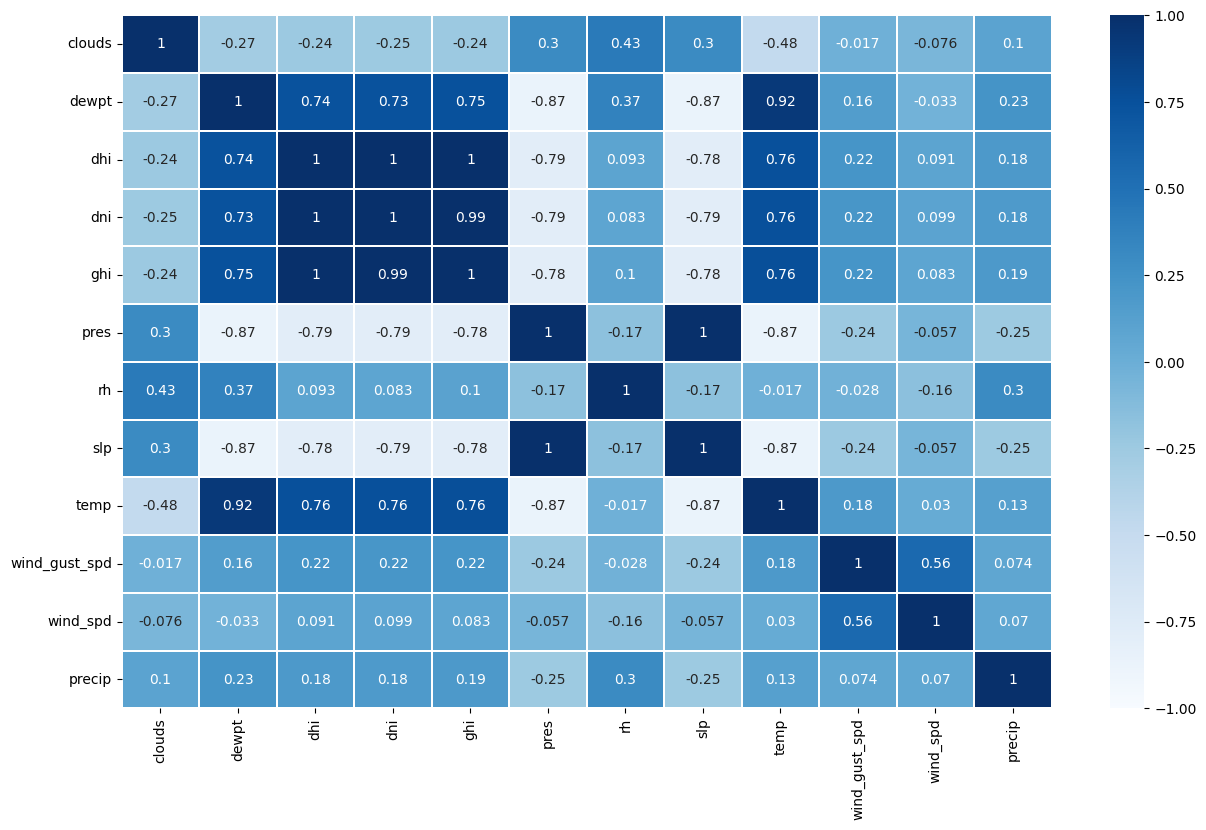

In [5]:
# Correlation HeatMap
import seaborn as sns
import pandas as pd

plt.figure(figsize=(15,9))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, linewidth=0.1, cmap="Blues",  vmin=-1, vmax=1)

plt.show()

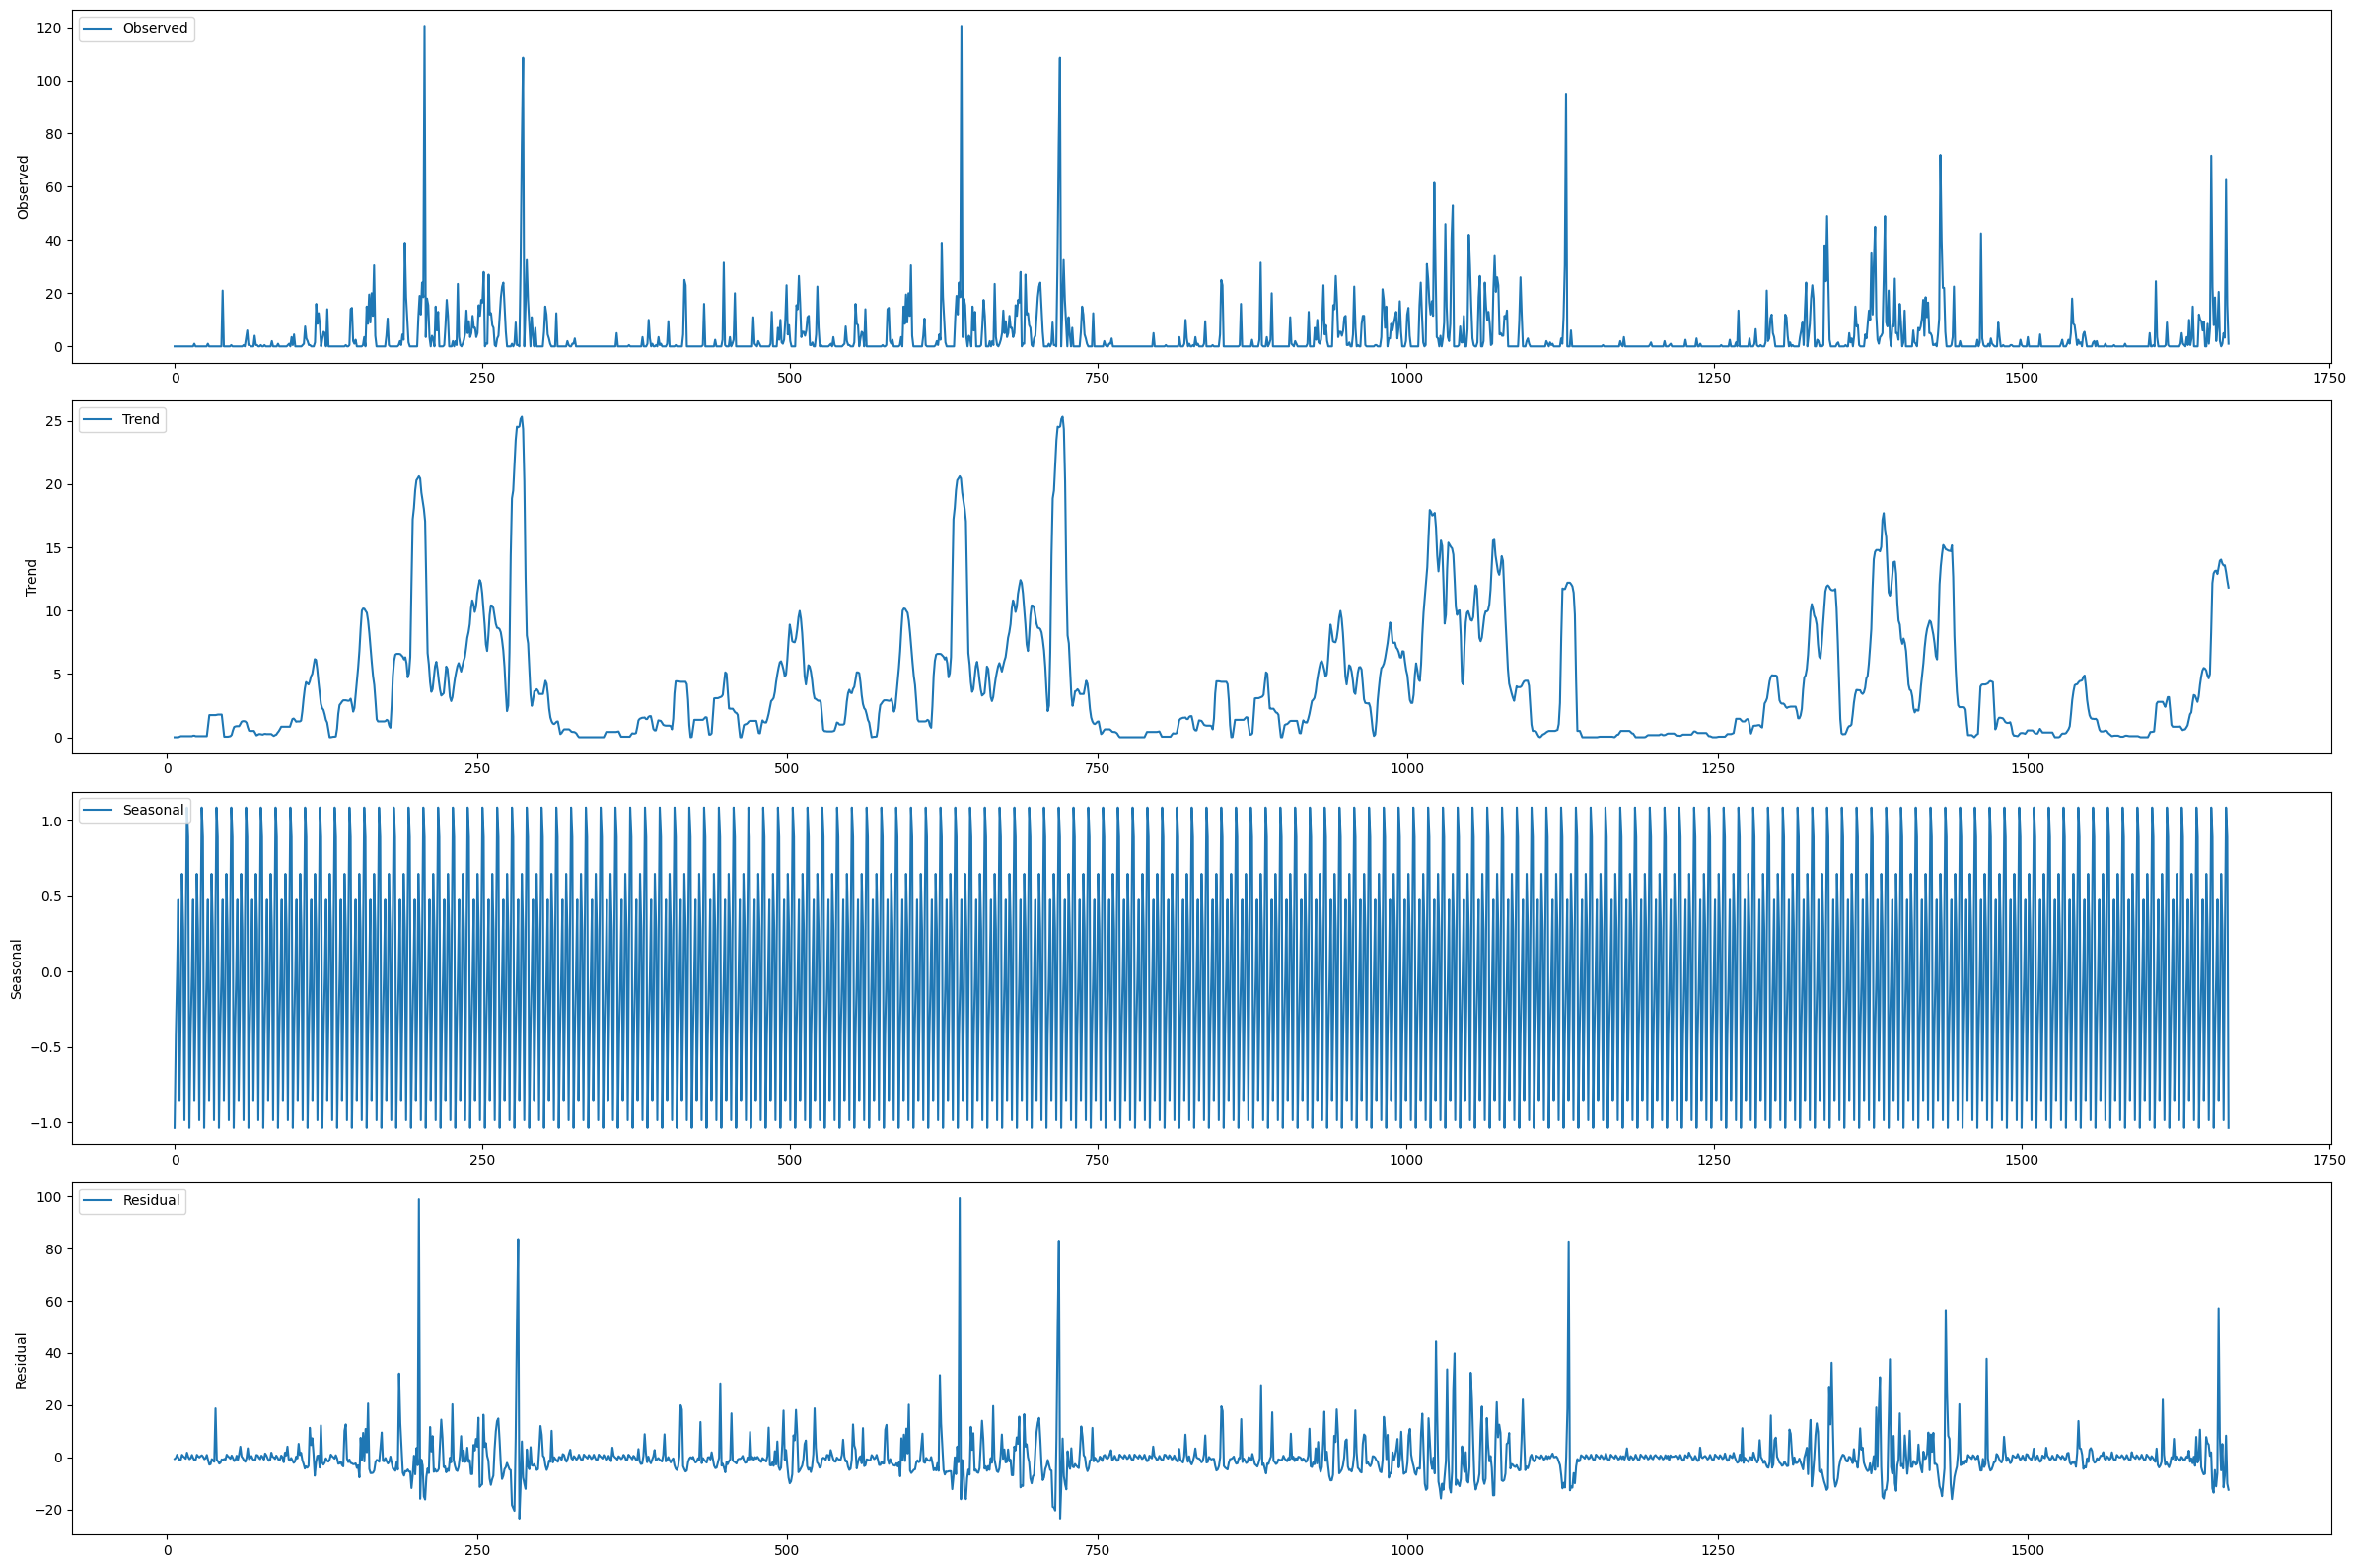

In [6]:
# Thực hiện phân tích theo mùa vụ
result = seasonal_decompose(df['precip'], model='additive', period=12)

# Vẽ các thành phần
plt.figure(figsize=(24, 16))

plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')
plt.ylabel('Observed')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

In [7]:
df.drop(columns=['datetime'], inplace=True)

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [9]:
train, test = train_test_split(df, test_size=0.1)
y_train = train['precip']
x_train = train.drop(columns='precip')
y_test = test['precip']
x_test = test.drop(columns='precip')

<h1>Mô hình LSTM</h1>

In [29]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(10, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(59))
model.add(Dense(25))
model.add(Dense(1))

# Compile mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(x_train, y_train, batch_size=1, epochs=10)


Epoch 1/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 119.1009
Epoch 2/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 116.9782
Epoch 3/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 107.7231
Epoch 4/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 68.8809
Epoch 5/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 128.5908
Epoch 6/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 108.4060
Epoch 7/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 78.7119
Epoch 8/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 85.8897
Epoch 9/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 87.9801
Epoch 10/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 65.0979


In [30]:
# Dự đoán trên tập kiểm tra
predictions = model.predict(x_test)

# Đánh giá mô hình
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step
Root Mean Squared Error: 8.912726271930978


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18496\542191952.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



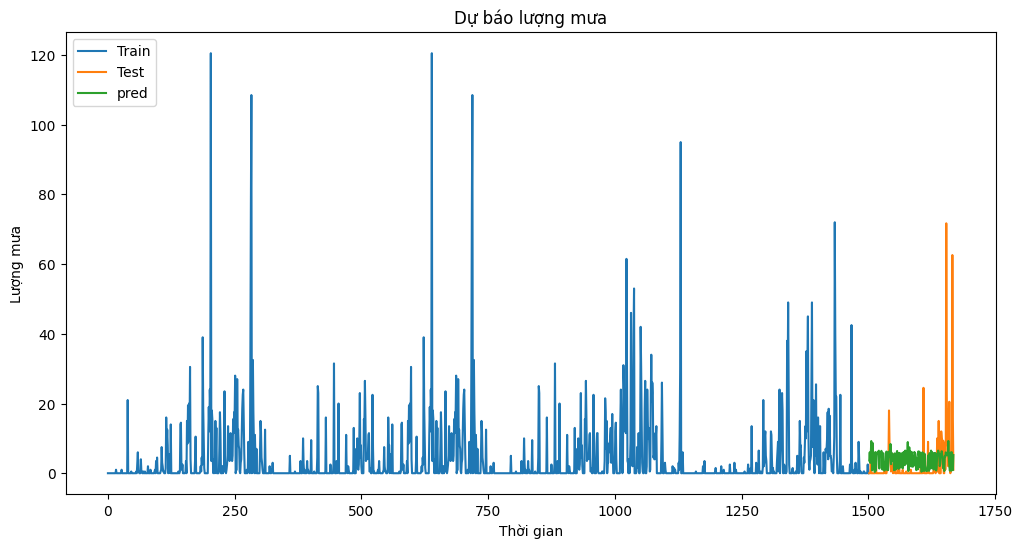

In [31]:
# Vẽ biểu đồ kết quả dự đoán
train_size = len(x_train)
train = df[:train_size]
valid = df[train_size:]
valid['pre_lstm'] = predictions

plt.figure(figsize=(12, 6))
plt.plot(train['precip'])
plt.plot(valid[['precip', 'pre_lstm']])
plt.title('Dự báo lượng mưa')
plt.xlabel('Thời gian')
plt.ylabel('Lượng mưa')
plt.legend(['Train', 'Test', 'pred'], loc='upper left')
plt.show()

<h1>XGBoost</h1>

In [26]:
# Tạo mô hình XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=14, n_estimators=140)

# Huấn luyện mô hình
model.fit(x_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(x_test)
# Đánh giá mô hình bằng RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 8.032327908584994


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18496\1172437490.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



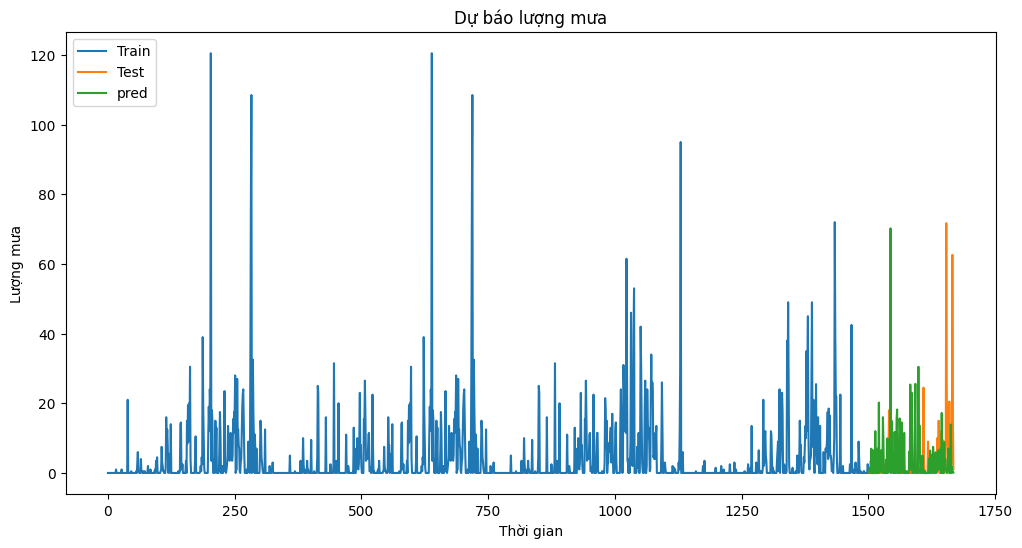

In [27]:
# Vẽ biểu đồ kết quả dự đoán
valid['pred_XGB'] = y_pred

plt.figure(figsize=(12, 6))
plt.plot(train['precip'])
plt.plot(valid[['precip', 'pred_XGB']])
plt.title('Dự báo lượng mưa')
plt.xlabel('Thời gian')
plt.ylabel('Lượng mưa')
plt.legend(['Train', 'Test', 'pred'], loc='upper left')
plt.show()

<h1>GRU</h1>

In [18]:
# Định nghĩa mô hình GRU
model = Sequential([
    Input(shape=(5, 1)),
    GRU(50),
    Dense(25),
    Dense(1)
])

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(x_train, y_train, epochs=10, batch_size=1)

Epoch 1/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 64.9752
Epoch 2/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 111.7701
Epoch 3/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 114.0757
Epoch 4/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 146.4620
Epoch 5/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 106.0252
Epoch 6/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 110.4110
Epoch 7/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 80.9995
Epoch 8/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 146.5063
Epoch 9/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 74.7685
Epoch 10/10
1502/1502 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 102.9000


In [20]:
# Dự đoán lượng mưa cho dữ liệu thử nghiệm (y_test)
predicted = model.predict(x_test)
# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicted))

print("RMSE:", rmse)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
RMSE: 8.903713693688337


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18496\1883010616.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



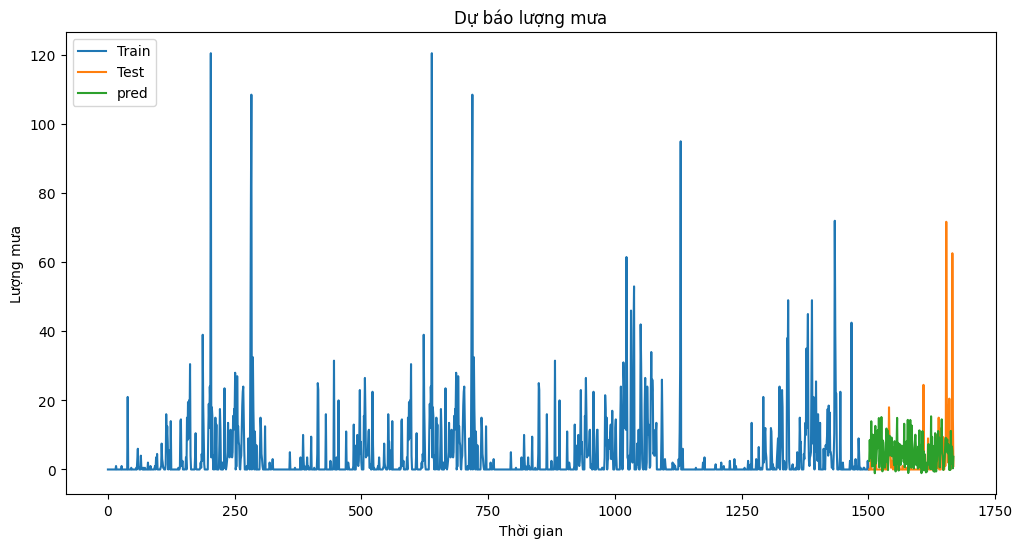

In [21]:
# Vẽ biểu đồ kết quả dự đoán
valid['pred_GRU'] = predicted

plt.figure(figsize=(12, 6))
plt.plot(train['precip'])
plt.plot(valid[['precip', 'pred_GRU']])
plt.title('Dự báo lượng mưa')
plt.xlabel('Thời gian')
plt.ylabel('Lượng mưa')
plt.legend(['Train', 'Test', 'pred'], loc='upper left')
plt.show()